Импортируем необходимые библиотеки

In [1]:
from datetime import datetime, date, timedelta
import time
import os
import glob
import psycopg2
import pandas as pd
import numpy as np
from scipy.stats import beta
from math import lgamma
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Загружаем csv и смотрим его содержимое

In [2]:
#команды для получения списка файлов в репозитории, где лежит текущий ноутбук
path = os.getcwd()
extension = 'csv'
os.chdir(path)
csv_all = glob.glob('*.{}'.format(extension))

name_search = 'claims' #ключевое слово для нашего файла с данными

csv_files = [a for a in csv_all if str(name_search) in a]
file_path_sym = str(str(path) + "\\" + str(csv_files[0]))
csv_unpack = pd.read_csv(file_path_sym,dtype=str)
pd_claim_csv = pd.DataFrame(csv_unpack) #записываем файл в pd датафрейм

In [3]:
print(pd_claim_csv[:25]) #отображаем получившийся df, чтобы посмотреть исходные данные

     MONTH SERVICE_CATEGORY                     CLAIM_SPECIALTY     PAYER  \
0   201801     AncillaryFFS                                 NaN   Payer F   
1   201801     AncillaryFFS                                 NaN   Payer H   
2   201801     AncillaryFFS                                 NaN   Payer O   
3   201801     AncillaryFFS                                 NaN   Payer W   
4   201801     AncillaryFFS                                 ACH   Payer W   
5   201801     AncillaryFFS      Advanced Registered Nurse Prac  Payer UN   
6   201801     AncillaryFFS                   ADVANCED RN PRACT  Payer CA   
7   201801     AncillaryFFS                           AMBULANCE  Payer CA   
8   201801     AncillaryFFS                           AMBULANCE  Payer CO   
9   201801     AncillaryFFS                           AMBULANCE   Payer F   
10  201801     AncillaryFFS                           AMBULANCE   Payer H   
11  201801     AncillaryFFS                           AMBULANCE   Payer O   

Переведём месяц в более корректный формат, уберем nan

In [4]:
def dt_trans(d):
    try:
        d2 = str(d)
        d3 = datetime(year=int(d[:4]), month=int(d[4:6]), day=int(1)).date()
    except:
        d3 = None
    return d3

In [5]:
field_group_1 = 'SERVICE_CATEGORY'
field_group_2 = 'CLAIM_SPECIALTY'

pd_df_stat = pd_claim_csv.fillna('-') #убираем NaN

pd_df_stat['business_mon'] = pd_df_stat['MONTH'].map(lambda x: dt_trans(x)) #форматируем месяц в дату с попмощью ранее 
                                                                                #написанной переменной

print(pd_df_stat.head(5))

    MONTH SERVICE_CATEGORY CLAIM_SPECIALTY    PAYER PAID_AMOUNT business_mon
0  201801     AncillaryFFS               -  Payer F        4281   2018-01-01
1  201801     AncillaryFFS               -  Payer H        2221   2018-01-01
2  201801     AncillaryFFS               -  Payer O        3937   2018-01-01
3  201801     AncillaryFFS               -  Payer W         268   2018-01-01
4  201801     AncillaryFFS             ACH  Payer W         151   2018-01-01


При проверке на корректность заполнения поля MONTH были обнаружены значения "201900". Для данного эксперимента будем считать, что это некорректная марикровка даты и исключим данные строки из аналитики (с примечанием).

In [6]:
#смотрим, какие строки в датафрейме не получили месяц в формате date:
df_ex = pd_df_stat[pd_df_stat['business_mon'].isna()==True] 

print(df_ex)

        MONTH    SERVICE_CATEGORY      CLAIM_SPECIALTY    PAYER PAID_AMOUNT  \
20778  201900        AncillaryFFS   HOME HEALTH CENTER  Payer H        -124   
20779  201900        AncillaryFFS       MEDICAL DOCTOR  Payer H        1568   
20780  201900        AncillaryFFS   PHYSICAL THERAPIST  Payer H          90   
20781  201900        AncillaryFFS  PHYSICIAN ASSISTANT  Payer H          84   
20782  201900        AncillaryFFS  SKILLED NURSING FAC  Payer H         -32   
20783  201900        AncillaryFFS     SPECIAL SERVICES  Payer H       -1956   
20784  201900          ERServices             HOSPITAL  Payer H       -3050   
20785  201900   InpatientServices             HOSPITAL  Payer H       -6150   
20786  201900   InpatientServices       MEDICAL DOCTOR  Payer H          75   
20787  201900  OutpatientServices             HOSPITAL  Payer H      -17235   
20788  201900         SNFServices       MEDICAL DOCTOR  Payer H         -77   

      business_mon  
20778         None  
20779    

In [7]:
#оставляем только строки с "корректной" датой 
pd_df_stat = pd_df_stat[pd_df_stat['business_mon'].isna()==False][['business_mon','SERVICE_CATEGORY','CLAIM_SPECIALTY'
                                                                   ,'PAYER','PAID_AMOUNT']]
#делаем бэкап df:
pd_df_stat_save = pd_df_stat

Интересно сравнить, как отличаются выплаты у разных страховых компаний в разрезе типов услуг и в целом общей динамики выплат. Для этого, посчитаем ряд статистических показателей. Это необходимо для общих выводов по статистике выплат компаний, плюс, позволит нам проанализировать потенциальные направления для дальнейшей аналитики:

In [8]:
list_payers = pd_df_stat['PAYER'].drop_duplicates().values.tolist()
new_column_1 = 'std_payer'# стандартное отклонение выплат в разрезе компаний
new_column_2 = 'sum_paid_amount_payer' # сумма выплат в разрезе компаний
new_column_3 = 'max_paid_amount_payer' # максимальное значение выплат в разрезе компаний
new_column_4 = 'min_paid_amount_payer' # минимальное значение выплат в разрезе компаний
new_column_5 = 'mean_paid_amount_payer' # среднее выплат в разрезе компаний

list_srv_cats = pd_df_stat['SERVICE_CATEGORY'].drop_duplicates().values.tolist()
new_column_6 = 'std' # стандартное отклонение выплат в разрезе компаний и типов услуг
new_column_7 = 'sum_paid_amount' # сумма выплат в разрезе компаний и типов услуг
new_column_8 = 'max_paid_amount' # максимальное значение выплат в разрезе компаний и типов услуг
new_column_9 = 'min_paid_amount' # минимальное значение выплат в разрезе компаний и типов услуг
new_column_10 = 'mean_paid_amount' # среднее выплат в разрезе компаний и типов услуг

pd_df_stat['PAID_AMOUNT'] = pd.to_numeric(pd_df_stat['PAID_AMOUNT'])

for n,i in enumerate(list_payers):
    pd_df_stat_temp = pd_df_stat[(pd_df_stat['PAYER'] == str(i))]
    paid_amount_array = np.array(pd_df_stat_temp['PAID_AMOUNT'].values.tolist())
    
    pd_df_stat.loc[pd_df_stat['PAYER'] == str(i), new_column_1] = float(np.std(paid_amount_array))
    pd_df_stat.loc[pd_df_stat['PAYER'] == str(i), new_column_2] = float(np.sum(paid_amount_array))
    pd_df_stat.loc[pd_df_stat['PAYER'] == str(i), new_column_3] = float(np.max(paid_amount_array))
    pd_df_stat.loc[pd_df_stat['PAYER'] == str(i), new_column_4] = float(np.min(paid_amount_array))
    pd_df_stat.loc[pd_df_stat['PAYER'] == str(i), new_column_5] = float(np.mean(paid_amount_array))
    
    for nn,ii in enumerate(list_srv_cats):
        try:
            pd_df_stat_temp_2 = pd_df_stat_temp[(pd_df_stat_temp['SERVICE_CATEGORY'] == str(ii))]
            paid_amount_array_sub = np.array(pd_df_stat_temp_2['PAID_AMOUNT'].values.tolist())

            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_6] = float(np.std(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_7] = float(np.sum(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_8] = float(np.max(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_9] = float(np.min(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_10] = float(np.mean(paid_amount_array_sub))
        except Exception as ex0:
            print('error -',ex0)
            pass

C:\Users\philk\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\philk\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\philk\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity


К общим показателям по компаниям добавим агрегированные данные по месяцам, в которые совершались выплаты:

In [9]:
field_group_1 = 'PAYER'
field_group_2 = 'business_mon'
field_group_3 = 'SERVICE_CATEGORY'

pd_df_stat_prep = pd_df_stat

#посчитаем общее количество выплат по компаниям, первый и последний месяц выплат 
pd_df_stat_prep['claim_count'] = pd_df_stat_prep.groupby(field_group_1)['PAID_AMOUNT'].transform('count')
pd_df_stat_prep['start_mon'] = pd_df_stat_prep.groupby(field_group_1)['business_mon'].transform('min')
pd_df_stat_prep['end_mon'] = pd_df_stat_prep.groupby(field_group_1)['business_mon'].transform('max')

#посмотрим количество месяцев, в которые совершались выплаты:
mon_count = pd_df_stat[[field_group_1,field_group_2]].drop_duplicates().sort_values([field_group_1,field_group_2],ascending=[False,False])
mon_count['count_months'] = mon_count.groupby(field_group_1)[field_group_2].transform('count')

#пора начать выводить результаты, чтобы мы могли сделать первые выводы:
pd_df_agg = pd.merge(pd_df_stat_prep, mon_count, on=[field_group_1], how='inner')
pd_df_agg['claim_sum_per_month'] = (pd.to_numeric(pd_df_agg['sum_paid_amount_payer'])/pd.to_numeric(pd_df_agg['count_months']))
pd_df_agg = pd_df_agg[[field_group_1,'claim_count',new_column_2,new_column_5,new_column_3,new_column_4,new_column_1
                        ,'claim_sum_per_month','count_months','start_mon','end_mon'
                        ]].drop_duplicates().sort_values('claim_count',ascending=False).reset_index(drop=True)

print(pd_df_agg[:50])

      PAYER  claim_count  sum_paid_amount_payer  mean_paid_amount_payer  \
0   Payer F         9020             86787408.0             9621.663858   
1  Payer CA         8681             33635443.0             3874.604654   
2   Payer W         7105             12180954.0             1714.419986   
3  Payer UN         6526              5988435.0              917.627184   
4   Payer O         6278             21419407.0             3411.820166   
5   Payer S         4189              3810748.0              909.703509   
6  Payer CO         3677              5068663.0             1378.477835   
7   Payer B         3631              2407509.0              663.042963   
8   Payer H         2349             21834697.0             9295.315879   
9  Payer UL          685               310027.0              452.594161   

   max_paid_amount_payer  min_paid_amount_payer     std_payer  \
0              2268611.0                    0.0  72294.479434   
1               879298.0                -510

По полученным данным уже можно сделать ряд наблюдений:

компания Payer F сделала наибольшее количество выплат (как по кличеству выплат, так и по общей сумме USD)

компания Payer UL сделала наименьшее количество выплат (как по кличеству выплат, так и по общей сумме USD). Выплаты эта компания начала совершать позже других (с ноября 2018 года), однако, за 20 месяцев выплат средняя сумма выплат у неё наименьшая из всех. Также, std выплат этой компании ниже остальных, что может указывать на то, что компания выплачивает страховые суммы по услугам с низким средним чеком (проверим далее в блоке по типам услуг)

также интересна компания Payer H, у неё высокий средний чек выплат, почти такой же, как и у Payer F, но при этом в 2 раза ниже std  и примерно в 3,5 раза ниже максимальная выплата, что может указывать на то, что Payer H фокусируется на опеределнной категории высокоплачиваемых услуг (это мы также проверим дальше).

также, консолидация сумм выплат наблюдается у компаний Payer UN, Payer B и Payer S (у всех 3 компаний консолидация в сторону низкооплачиваемый услуг).

Однако, по полученным предварительным данным есть также 2 момента, которые нужно проверить для корректности сравнивания компаний:

- наблюдаются отрицательные суммы выплат. Здесь делаем допущение, что это результат перерасчёта/возвраты выплат. Выделим эту категорию отдельно, чтобы проанализировать такие кейсы.
- некоторые компании совершали выплаты вплоть до 2020-07-01. Проверим это отдельно, так как есть вероятность, что наша статистика захватывает только часть этого месяца.

Поверка 2020-07-01:

In [10]:
#переменная для перевода формата даты из str в date
def dt_get(d):
    return datetime.strptime(str(d),'%Y-%m-%d').date()

In [11]:
#разделяем данные по выплатам на июль 2020 и период с 2019-01-01 по 2020-06-01
target_dt_1 = '2020-07-01'
target_dt_2 = '2019-01-01'
pd_df_stat_prep = pd_df_stat
pd_df_stat_prep_1 = pd_df_stat_prep[(pd_df_stat_prep['business_mon']==dt_get(target_dt_1))]
pd_df_stat_prep_2 = pd_df_stat_prep[(pd_df_stat_prep['business_mon']<dt_get(target_dt_1))&(pd_df_stat_prep['business_mon']>=dt_get(target_dt_2))]

print(pd_df_stat_prep_1[:50])

      business_mon    SERVICE_CATEGORY         CLAIM_SPECIALTY    PAYER  \
52085   2020-07-01        AncillaryFFS               AMBULANCE  Payer H   
52086   2020-07-01        AncillaryFFS        ANESTHESIOLOGIST  Payer H   
52087   2020-07-01        AncillaryFFS             HOME HEALTH  Payer F   
52088   2020-07-01        AncillaryFFS      HOME HEALTH CENTER  Payer H   
52089   2020-07-01        AncillaryFFS         INDEPENDENT LAB  Payer H   
52090   2020-07-01        AncillaryFFS          MEDICAL DOCTOR  Payer H   
52091   2020-07-01        AncillaryFFS  MEDICAL SUPPLIER (DME)  Payer F   
52092   2020-07-01        AncillaryFFS  MEDICAL SUPPLIER (DME)  Payer O   
52093   2020-07-01        AncillaryFFS     NURSE PRACTITIONERS  Payer H   
52094   2020-07-01        AncillaryFFS               OSTEOPATH  Payer H   
52095   2020-07-01        AncillaryFFS        OTHER SPECIALIST  Payer H   
52096   2020-07-01        AncillaryFFS              PODIATRIST  Payer H   
52097   2020-07-01       

In [12]:
field_group_1 = 'PAYER'
field_group_2 = 'business_mon'
field_group_3 = 'SERVICE_CATEGORY'

#считаем количество выплат за июль 2020
pd_df_stat_prep_1['claim_count_test'] = pd_df_stat_prep_1.groupby([field_group_1,field_group_3])['PAID_AMOUNT'].transform('count')

#считаем среднее количество выплат по услугам в предыдщий период (для этого находим общее количество выплат за период и 
    #делим полученный показатель на количество месяцев)
pd_df_stat_prep_2['claim_count_control'] = pd_df_stat_prep_2.groupby([field_group_1,field_group_3])['PAID_AMOUNT'].transform('count')
mon_count = pd_df_stat_prep_2[[field_group_1,field_group_2]].drop_duplicates().sort_values([field_group_1,field_group_2],ascending=[False,False])
mon_count['count_months_control'] = mon_count.groupby(field_group_1)[field_group_2].transform('count')
pd_df_stat_prep_2 = pd.merge(pd_df_stat_prep_2, mon_count, on=field_group_1, how='inner')

#расчитываем показатели и джойним датафреймы, чтобы сравнить, сколько выплат по типам услуг было в июле 2020, а сколько 
    #в среднем было за 1,5 года до июля по тем же типам услуг
pd_df_stat_prep_1 = pd_df_stat_prep_1[[field_group_2,field_group_1,field_group_3,'claim_count_test']].drop_duplicates().sort_values('claim_count_test',ascending=False)
pd_df_stat_prep_2 = pd_df_stat_prep_2[[field_group_1,field_group_3,'count_months_control','claim_count_control']].drop_duplicates().sort_values('claim_count_control',ascending=False)
pd_df_stat_prep_2['claim_count_control'] = (pd.to_numeric(pd_df_stat_prep_2['claim_count_control'])/pd.to_numeric(pd_df_stat_prep_2['count_months_control']))

pd_df_stat_prep_fin = pd.merge(pd_df_stat_prep_1, pd_df_stat_prep_2, on=[field_group_1,field_group_3], how='inner')

#выводим результат:
print(pd_df_stat_prep_fin[[field_group_2,field_group_1,field_group_3,'claim_count_test','claim_count_control']])

C:\Users\philk\AppData\Local\Temp\ipykernel_14764\4005667945.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat_prep_1['claim_count_test'] = pd_df_stat_prep_1.groupby([field_group_1,field_group_3])['PAID_AMOUNT'].transform('count')
C:\Users\philk\AppData\Local\Temp\ipykernel_14764\4005667945.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat_prep_2['claim_count_control'] = pd_df_stat_prep_2.groupby([field_group_1,field_group_3])['PAID_AMOUNT'].transform('count')


   business_mon    PAYER    SERVICE_CATEGORY  claim_count_test  \
0    2020-07-01  Payer H      SpecialistsFFS                15   
1    2020-07-01  Payer H        AncillaryFFS                10   
2    2020-07-01  Payer H   InpatientServices                 9   
3    2020-07-01  Payer H  OutpatientServices                 9   
4    2020-07-01  Payer F      SpecialistsFFS                 6   
5    2020-07-01  Payer H          ERServices                 5   
6    2020-07-01  Payer H         ASCServices                 4   
7    2020-07-01  Payer H         SNFServices                 3   
8    2020-07-01  Payer F        AncillaryFFS                 2   
9    2020-07-01  Payer H              PCPFFS                 2   
10   2020-07-01  Payer O        AncillaryFFS                 1   
11   2020-07-01  Payer H        PCPEncounter                 1   

    claim_count_control  
0             16.833333  
1             15.611111  
2             13.500000  
3             11.833333  
4          

Судя по статистике, можно предположить, что данные за июль 2020 года могут быть не полными (сильно просели выплаты по категориям SpecialistsFFS и AncillaryFFS у Payer F, а также категория AncillaryFFS у Payer O). Однако, данные по Payer H сходятся, из чего делаем допущение, что данные за июль 2020 полные только у Payer H (проверим этот тезис позже, когда будем смотреть исторические данные по выплатам).

Пока же убираем июль 2020 у Payer O и Payer F

In [13]:
#проверяем, убрали ли исключения:
pd_df_stat_prep = pd_df_stat
pd_df_stat_exception = pd_df_stat_prep[((pd_df_stat_prep[field_group_1]=='Payer H') & (pd_df_stat_prep[field_group_2]==dt_get(target_dt_1)))
                                      |(pd_df_stat_prep[field_group_2]<dt_get(target_dt_1))]

pd_df_stat_exception['max_month'] = pd_df_stat_exception.groupby(field_group_1)[field_group_2].transform('max')
pd_df_stat_exception['min_month'] = pd_df_stat_exception.groupby(field_group_1)[field_group_2].transform('min')
pd_df_stat_exception = pd_df_stat_exception[[field_group_1,'max_month','min_month']].drop_duplicates()

print(pd_df_stat_exception)

          PAYER   max_month   min_month
0       Payer F  2020-06-01  2018-01-01
1       Payer H  2020-07-01  2018-01-01
2       Payer O  2020-06-01  2018-01-01
3       Payer W  2020-06-01  2018-01-01
5      Payer UN  2020-06-01  2018-01-01
6      Payer CA  2020-06-01  2018-01-01
8      Payer CO  2020-06-01  2018-01-01
12      Payer S  2020-06-01  2018-01-01
14      Payer B  2020-06-01  2018-01-01
17474  Payer UL  2020-06-01  2018-11-01


C:\Users\philk\AppData\Local\Temp\ipykernel_14764\1265439950.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat_exception['max_month'] = pd_df_stat_exception.groupby(field_group_1)[field_group_2].transform('max')
C:\Users\philk\AppData\Local\Temp\ipykernel_14764\1265439950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat_exception['min_month'] = pd_df_stat_exception.groupby(field_group_1)[field_group_2].transform('min')


In [14]:
#перезаписываем наш датафрейм с исключениями:
pd_df_stat = pd_df_stat_save[((pd_df_stat_save[field_group_1]=='Payer H') & (pd_df_stat_save[field_group_2]==dt_get(target_dt_1)))
                                      |(pd_df_stat_save[field_group_2]<dt_get(target_dt_1))]
#бэкап:
pd_df_stat_save = pd_df_stat

Теперь можем сравнить данные компаний по типам услуг, а также историческую динамику:

Сначала группируем по типам услуг

In [15]:
pd_df_stat = pd_df_stat_save

In [16]:
list_payers = pd_df_stat['PAYER'].drop_duplicates().values.tolist()
list_srv_cats = pd_df_stat['SERVICE_CATEGORY'].drop_duplicates().values.tolist()
new_column_6 = 'std' # стандартное отклонение выплат в разрезе компаний и типов услуг
new_column_7 = 'sum_paid_amount' # сумма выплат в разрезе компаний и типов услуг
new_column_8 = 'max_paid_amount' # максимальное значение выплат в разрезе компаний и типов услуг
new_column_9 = 'min_paid_amount' # минимальное значение выплат в разрезе компаний и типов услуг
new_column_10 = 'mean_paid_amount' # среднее выплат в разрезе компаний и типов услуг
new_column_11 = 'count_claim' # количество выплат в разрезе компаний и типов услуг

pd_df_stat['PAID_AMOUNT'] = pd.to_numeric(pd_df_stat['PAID_AMOUNT'])

for n,i in enumerate(list_payers):
    pd_df_stat_temp = pd_df_stat[(pd_df_stat['PAYER'] == str(i))]
    for nn,ii in enumerate(list_srv_cats):
        try:
            pd_df_stat_temp_2 = pd_df_stat_temp[(pd_df_stat_temp['SERVICE_CATEGORY'] == str(ii))]
            paid_amount_array_sub = np.array(pd_df_stat_temp_2['PAID_AMOUNT'].values.tolist())

            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_6] = float(np.std(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_7] = float(np.sum(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_8] = float(np.max(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_9] = float(np.min(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_10] = float(np.mean(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_11] = float(len(pd_df_stat_temp_2['PAID_AMOUNT'].values.tolist()))
        except Exception as ex0:
            print('error -',ex0)
            pass
        
pd_df_stat = pd_df_stat[['PAYER','SERVICE_CATEGORY',new_column_11,new_column_7,new_column_10,new_column_6
                        ,new_column_8,new_column_9
                        ]].drop_duplicates().reset_index(drop=True)

C:\Users\philk\AppData\Local\Temp\ipykernel_14764\1617224769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat['PAID_AMOUNT'] = pd.to_numeric(pd_df_stat['PAID_AMOUNT'])
C:\Users\philk\AppData\Local\Temp\ipykernel_14764\1617224769.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_11] = float(len(pd_df_stat_temp_2['PAID_AMOUNT'].values.tolist()))
C:\Users\philk\anaconda3\lib\site-packages\

error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity


In [17]:
print(pd_df_stat.sort_values(['PAYER',new_column_7],ascending=[True,False]))

pd_df_stat_agg = pd_df_stat

       PAYER    SERVICE_CATEGORY  count_claim  sum_paid_amount  \
35   Payer B   InpatientServices        532.0         676088.0   
78   Payer B      SpecialistsFFS       1210.0         625501.0   
40   Payer B  OutpatientServices        405.0         350974.0   
8    Payer B        AncillaryFFS        771.0         328378.0   
11   Payer B         ASCServices        208.0         155004.0   
25   Payer B          ERServices        223.0         140072.0   
55   Payer B              PCPFFS         85.0          68758.0   
62   Payer B         SNFServices         97.0          62734.0   
47   Payer B        PCPEncounter        100.0              0.0   
29  Payer CA   InpatientServices       1731.0       16477077.0   
71  Payer CA      SpecialistsFFS       2137.0        4860522.0   
38  Payer CA  OutpatientServices       1387.0        4497712.0   
5   Payer CA        AncillaryFFS       1436.0        2591489.0   
20  Payer CA          ERServices        726.0        1785795.0   
63  Payer 

Посмотрим визуализацию агрегированных показателей по категориям услуг:

<Figure size 432x288 with 0 Axes>

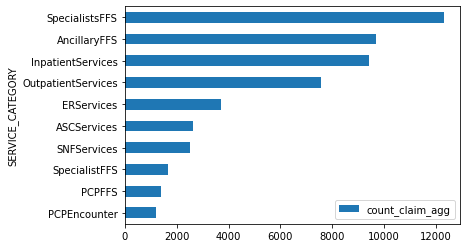

<Figure size 432x288 with 0 Axes>

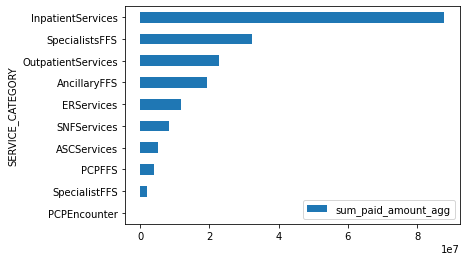

<Figure size 432x288 with 0 Axes>

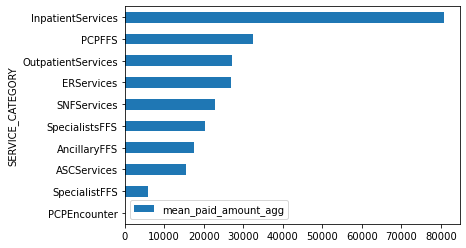

<Figure size 432x288 with 0 Axes>

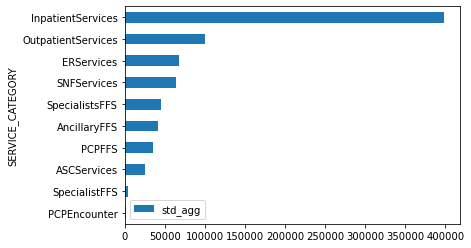

<Figure size 432x288 with 0 Axes>

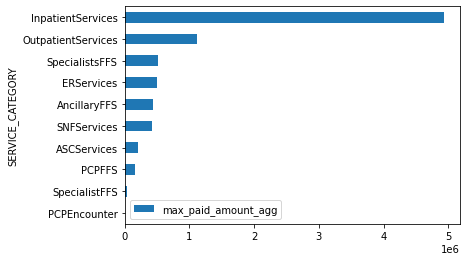

<Figure size 432x288 with 0 Axes>

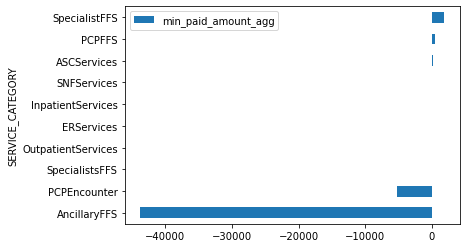

In [18]:
agg_columns = [new_column_11,new_column_7,new_column_10,new_column_6,new_column_8,new_column_9]

for i,col in enumerate(agg_columns):
    agg_column_1 = col
    serv_graph = pd_df_stat_agg
    serv_graph[str(agg_column_1+'_agg')] = pd_df_stat_agg.groupby('SERVICE_CATEGORY')[agg_column_1].transform('sum')
    serv_graph = pd_df_stat_agg[['SERVICE_CATEGORY',str(agg_column_1+'_agg')]].drop_duplicates().sort_values(str(agg_column_1+'_agg'),ascending=True).set_index('SERVICE_CATEGORY')

    plt.figure()
    serv_graph.plot.barh(stacked=True)

Можно сделать общие выводы по категориям услуг:
    
SpecialistsFFS - выплаты встречаются чаще всего

InpatientServices - в этой категории наибольшая общая сумма выплат, а также стандартное отклонение сумм

PCPFFS - не частая категория, однако с высокой средней суммой и относительно низким стандартным отклонениям (суммы выплат в жтой категории "кучкуются")

Чтобы посмотреть наши предыдущие гипотезы по профилю компаний, посмотрим топ-3 категории для каждой:

In [19]:
agg_columns = [new_column_11,new_column_7]

for i,col in enumerate(agg_columns):
    agg_column_1 = col
    pd_df_stat['rank'] = pd.to_numeric(pd_df_stat.groupby(['PAYER'])[agg_column_1].rank(ascending=False))
    pd_df_stat_temp = pd_df_stat[(pd_df_stat['rank']<=3)].reset_index(drop=True)[['PAYER'
                                                                                  ,'SERVICE_CATEGORY'
                                                                                  #,col
                                                                                  ,'mean_paid_amount'
                                                                                 #,'std'
                                                                                 ,'rank']].sort_values(['PAYER','rank'],ascending=[True,True])
    print('Ранг по показателю',col)
    print(pd_df_stat_temp)

Ранг по показателю count_claim
       PAYER   SERVICE_CATEGORY  mean_paid_amount  rank
26   Payer B     SpecialistsFFS        516.942975   1.0
8    Payer B       AncillaryFFS        425.911803   2.0
17   Payer B  InpatientServices       1270.842105   3.0
19  Payer CA     SpecialistsFFS       2274.460459   1.0
11  Payer CA  InpatientServices       9518.819757   2.0
5   Payer CA       AncillaryFFS       1804.658078   3.0
22  Payer CO     SpecialistsFFS        984.393369   1.0
6   Payer CO       AncillaryFFS       1466.595598   2.0
14  Payer CO  InpatientServices       2402.381089   3.0
20   Payer F     SpecialistsFFS       7375.658001   1.0
9    Payer F  InpatientServices      23869.715298   2.0
0    Payer F       AncillaryFFS       5096.901372   3.0
24   Payer H     SpecialistsFFS       5071.840671   1.0
1    Payer H       AncillaryFFS       3484.199105   2.0
10   Payer H  InpatientServices      27383.563776   3.0
21   Payer O     SpecialistsFFS       2356.044551   1.0
12   Payer O  Inp

Для более удобного просмотра, разобьём категории на конкретные места в топ-3:

In [20]:
agg_columns = [new_column_11,new_column_7]

for i,col in enumerate(agg_columns):
    agg_column_1 = col
    pd_df_stat['rank'] = pd.to_numeric(pd_df_stat.groupby(['PAYER'])[agg_column_1].rank(ascending=False))
    for x in range(3):
        pd_df_stat_temp = pd_df_stat[(pd_df_stat['rank']==x+1)].reset_index(drop=True)[['PAYER'
                                                                                      ,'SERVICE_CATEGORY'
                                                                                      #,col
                                                                                      ,'mean_paid_amount'
                                                                                     #,'std'
                                                                                     ,'rank']].sort_values(['PAYER','rank'],ascending=[True,True])
        print(f'Ранг #{x+1} по показателю',col)
        print(pd_df_stat_temp)

Ранг #1 по показателю count_claim
      PAYER SERVICE_CATEGORY  mean_paid_amount  rank
8   Payer B   SpecialistsFFS        516.942975   1.0
1  Payer CA   SpecialistsFFS       2274.460459   1.0
4  Payer CO   SpecialistsFFS        984.393369   1.0
2   Payer F   SpecialistsFFS       7375.658001   1.0
6   Payer H   SpecialistsFFS       5071.840671   1.0
3   Payer O   SpecialistsFFS       2356.044551   1.0
7   Payer S   SpecialistsFFS        684.406552   1.0
9  Payer UL    SpecialistFFS        362.257812   1.0
0  Payer UN     AncillaryFFS        133.248652   1.0
5   Payer W   SpecialistsFFS        975.273759   1.0
Ранг #2 по показателю count_claim
      PAYER   SERVICE_CATEGORY  mean_paid_amount  rank
3   Payer B       AncillaryFFS        425.911803   2.0
5  Payer CA  InpatientServices       9518.819757   2.0
2  Payer CO       AncillaryFFS       1466.595598   2.0
4   Payer F  InpatientServices      23869.715298   2.0
0   Payer H       AncillaryFFS       3484.199105   2.0
6   Payer O  Inpati

Проверим профиль компаний, интересные данные по которым мы заметили при взгляде на общие агрегированные показатели:

у компаний Payer F и Payer H высокий средний чек в категории InpatientServices - первой категории по общей сумме выплат, в остальныз категориях среняя сумма выплат у этих компаний также выше. 

у компании Payer UN отличается профиль фокусировки на группах услуг. Например, у данной компании первая категория по количеству выплат AncillaryFFS, а не SpecialistsFFS, как у остальных компаний, а по сумме выплат SpecialistFFS, вместо InpatientServices, как у остальных. У категории AncillaryFFS низкий STD выплат, что объясняет наши прошлые выводы по компании Payer UN.

у компании Payer UL на первом месте по количеству выплат идёт категория SpecialistFFS, которая находится ниже другиз по средней сумме выплат и std, что объясняет наши первичные выводы по данной компании.

неоднозначно смотрится статистика по компаниям Payer H, Payer B и Payer S. Если то, что выплаты компании Payer H в два раза меньше разбросаня, чем у лидера по средней сумме выплат Payer F, можно объяснить высокой долей категории AncillaryFFS в ее выплатах, то Payer B и Payer S по категориям не выделяются, при этом имея низкие средние показатели выплат.

Посмотрим ситуацию с выплатами по месяцам (исторические данные):

Для начала проверим, как распределялись категории услуг у компаний в первые 1,5 года статистики, чтобы лучше понять, выделяется ли стратегия компании Payer UN (важно помнить, что остальные компании могли не начать работать в январе 2018 года, так что вывод в любом случае будет неоднозначный)

In [21]:
pd_df_stat = pd_df_stat_save

target_dt = '2019-07-01'
pd_df_stat = pd_df_stat[(pd_df_stat['business_mon']<=dt_get(target_dt))]

print(pd_df_stat.head(5))

  business_mon SERVICE_CATEGORY CLAIM_SPECIALTY    PAYER  PAID_AMOUNT  \
0   2018-01-01     AncillaryFFS               -  Payer F         4281   
1   2018-01-01     AncillaryFFS               -  Payer H         2221   
2   2018-01-01     AncillaryFFS               -  Payer O         3937   
3   2018-01-01     AncillaryFFS               -  Payer W          268   
4   2018-01-01     AncillaryFFS             ACH  Payer W          151   

      std_payer  sum_paid_amount_payer  max_paid_amount_payer  \
0  72294.479434             86787408.0              2268611.0   
1  37541.166102             21834697.0               621368.0   
2  19631.042892             21419407.0               476017.0   
3   9451.409586             12180954.0               261963.0   
4   9451.409586             12180954.0               261963.0   

   min_paid_amount_payer  mean_paid_amount_payer           std  \
0                    0.0             9621.663858  12600.272640   
1                 -408.0             9

In [22]:
list_payers = pd_df_stat['PAYER'].drop_duplicates().values.tolist()
list_srv_cats = pd_df_stat['SERVICE_CATEGORY'].drop_duplicates().values.tolist()
new_column_6 = 'std' # стандартное отклонение выплат в разрезе компаний и типов услуг
new_column_7 = 'sum_paid_amount' # сумма выплат в разрезе компаний и типов услуг
new_column_8 = 'max_paid_amount' # максимальное значение выплат в разрезе компаний и типов услуг
new_column_9 = 'min_paid_amount' # минимальное значение выплат в разрезе компаний и типов услуг
new_column_10 = 'mean_paid_amount' # среднее выплат в разрезе компаний и типов услуг
new_column_11 = 'count_claim' # количество выплат в разрезе компаний и типов услуг

pd_df_stat['PAID_AMOUNT'] = pd.to_numeric(pd_df_stat['PAID_AMOUNT'])

for n,i in enumerate(list_payers):
    pd_df_stat_temp = pd_df_stat[(pd_df_stat['PAYER'] == str(i))]
    for nn,ii in enumerate(list_srv_cats):
        try:
            pd_df_stat_temp_2 = pd_df_stat_temp[(pd_df_stat_temp['SERVICE_CATEGORY'] == str(ii))]
            paid_amount_array_sub = np.array(pd_df_stat_temp_2['PAID_AMOUNT'].values.tolist())

            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_6] = float(np.std(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_7] = float(np.sum(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_8] = float(np.max(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_9] = float(np.min(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_10] = float(np.mean(paid_amount_array_sub))
            pd_df_stat.loc[(pd_df_stat['PAYER'] == str(i)) & (pd_df_stat['SERVICE_CATEGORY'] == str(ii)), new_column_11] = float(len(pd_df_stat_temp_2['PAID_AMOUNT'].values.tolist()))
        except Exception as ex0:
            print('error -',ex0)
            pass
        
pd_df_stat = pd_df_stat[['PAYER','SERVICE_CATEGORY',new_column_11,new_column_7,new_column_10,new_column_6
                        ,new_column_8,new_column_9
                        ]].drop_duplicates().reset_index(drop=True)

C:\Users\philk\AppData\Local\Temp\ipykernel_14764\1617224769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat['PAID_AMOUNT'] = pd.to_numeric(pd_df_stat['PAID_AMOUNT'])
C:\Users\philk\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\philk\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\philk\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity
error - zero-size array to reduction operation maximum which has no identity


In [23]:
agg_columns = [new_column_11,new_column_7]

for i,col in enumerate(agg_columns):
    agg_column_1 = col
    pd_df_stat['rank'] = pd.to_numeric(pd_df_stat.groupby(['PAYER'])[agg_column_1].rank(ascending=False))
    for x in range(3):
        pd_df_stat_temp = pd_df_stat[(pd_df_stat['rank']==x+1)].reset_index(drop=True)[['PAYER'
                                                                                      ,'SERVICE_CATEGORY'
                                                                                      #,col
                                                                                      ,'mean_paid_amount'
                                                                                     #,'std'
                                                                                     ,'rank']].sort_values(['PAYER','rank'],ascending=[True,True])
        print(f'Ранг #{x+1} по показателю',col)
        print(pd_df_stat_temp)

Ранг #1 по показателю count_claim
      PAYER SERVICE_CATEGORY  mean_paid_amount  rank
8   Payer B   SpecialistsFFS        475.072829   1.0
1  Payer CA   SpecialistsFFS       2279.934877   1.0
4  Payer CO   SpecialistsFFS        984.623025   1.0
2   Payer F   SpecialistsFFS       7448.790071   1.0
6   Payer H   SpecialistsFFS       4716.770073   1.0
3   Payer O   SpecialistsFFS       2456.770321   1.0
7   Payer S   SpecialistsFFS        668.807330   1.0
9  Payer UL    SpecialistFFS        374.440559   1.0
0  Payer UN     AncillaryFFS        -32.356598   1.0
5   Payer W   SpecialistsFFS        928.871525   1.0
Ранг #2 по показателю count_claim
      PAYER   SERVICE_CATEGORY  mean_paid_amount  rank
2   Payer B       AncillaryFFS        349.342857   2.0
4  Payer CA  InpatientServices       9536.604545   2.0
6  Payer CO  InpatientServices       2395.286751   2.0
3   Payer F  InpatientServices      25598.989652   2.0
0   Payer H       AncillaryFFS       3422.790698   2.0
5   Payer O  Inpati

Данные компании Payer UN отличаются от ранних показателей остальных компаний, это усиливает вывод о том, что стратегия Payer UN принципиально отличается от остальных компаний

Вернемся к статистике по месяцам:

In [24]:
#агрегирование данных по месяцам:
pd_df_stat = pd_df_stat_save

field_group_1 = 'PAYER'
field_group_2 = 'business_mon'
field_group_3 = 'SERVICE_CATEGORY'

pd_df_stat = pd_df_stat[[field_group_1,field_group_2,field_group_3,'CLAIM_SPECIALTY','PAID_AMOUNT']]

pd_df_stat['claim_count'] = pd_df_stat_prep.groupby([field_group_1,field_group_2])['PAID_AMOUNT'].transform('count')
pd_df_stat['mean_paid_amount'] = pd_df_stat_prep.groupby([field_group_1,field_group_2])['PAID_AMOUNT'].transform('mean')

pd_df_stat = pd_df_stat[[field_group_1,field_group_2,'claim_count','mean_paid_amount']].drop_duplicates().sort_values(['PAYER','business_mon'], ascending = [True,False]).reset_index(drop=True)

print(pd_df_stat.head(50))

       PAYER business_mon  claim_count  mean_paid_amount
0    Payer B   2020-06-01          123        614.747967
1    Payer B   2020-05-01          147        878.802721
2    Payer B   2020-04-01          117        661.675214
3    Payer B   2020-03-01          148        689.310811
4    Payer B   2020-02-01          154        765.337662
5    Payer B   2020-01-01          149        766.161074
6    Payer B   2019-12-01          130        869.823077
7    Payer B   2019-11-01          121        881.099174
8    Payer B   2019-10-01          134        786.768657
9    Payer B   2019-09-01          100        548.920000
10   Payer B   2019-08-01          128        766.492188
11   Payer B   2019-07-01          126        686.468254
12   Payer B   2019-06-01          108        482.092593
13   Payer B   2019-05-01          117        751.675214
14   Payer B   2019-04-01          100        530.650000
15   Payer B   2019-03-01          105        566.266667
16   Payer B   2019-02-01      

C:\Users\philk\AppData\Local\Temp\ipykernel_14764\3925832062.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat['claim_count'] = pd_df_stat_prep.groupby([field_group_1,field_group_2])['PAID_AMOUNT'].transform('count')
C:\Users\philk\AppData\Local\Temp\ipykernel_14764\3925832062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_stat['mean_paid_amount'] = pd_df_stat_prep.groupby([field_group_1,field_group_2])['PAID_AMOUNT'].transform('mean')


Нарисуем графики данных по платежам по месяцам:

Количество платежей:

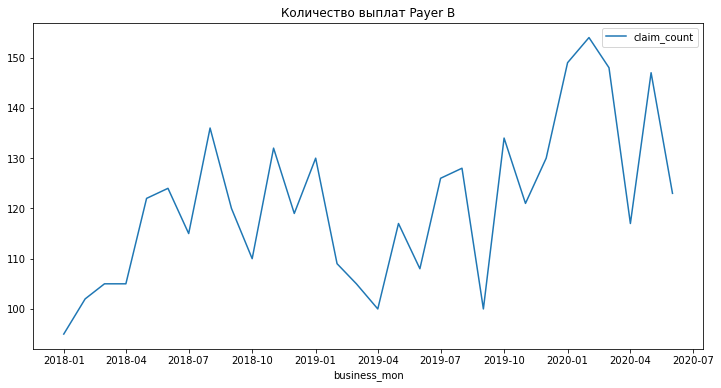

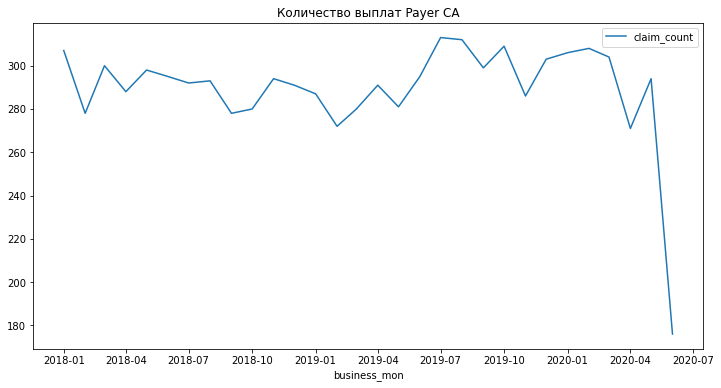

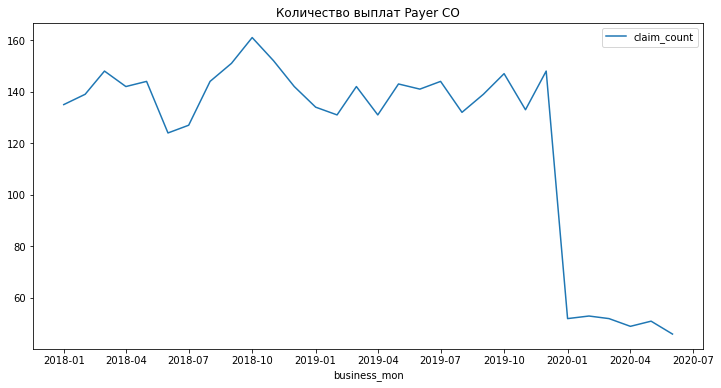

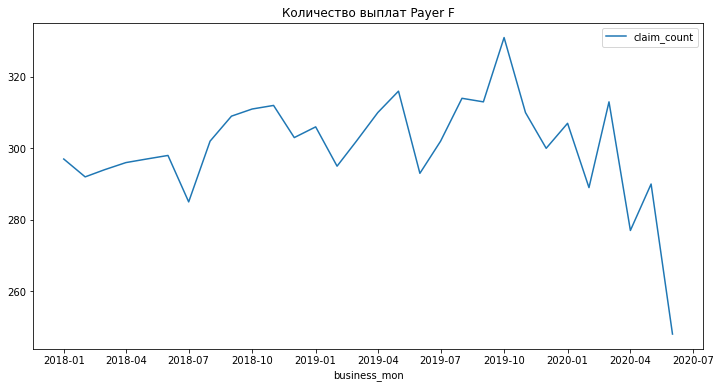

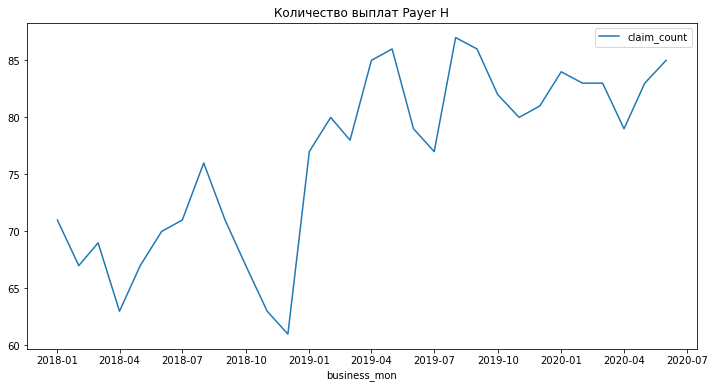

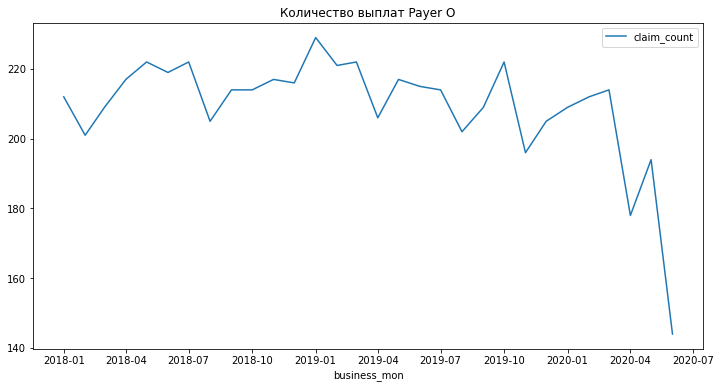

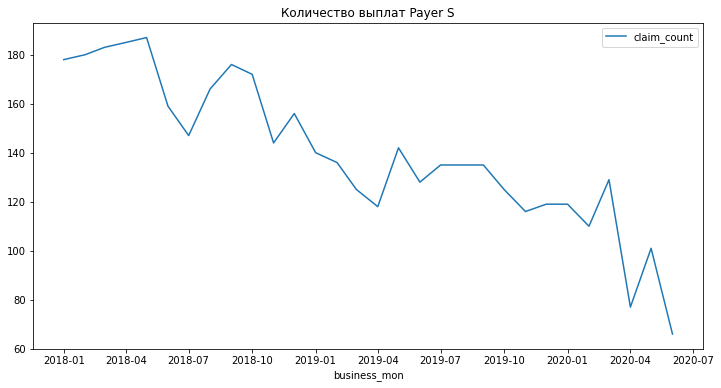

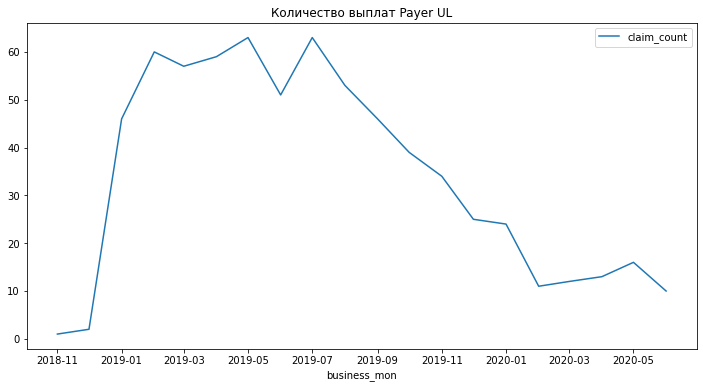

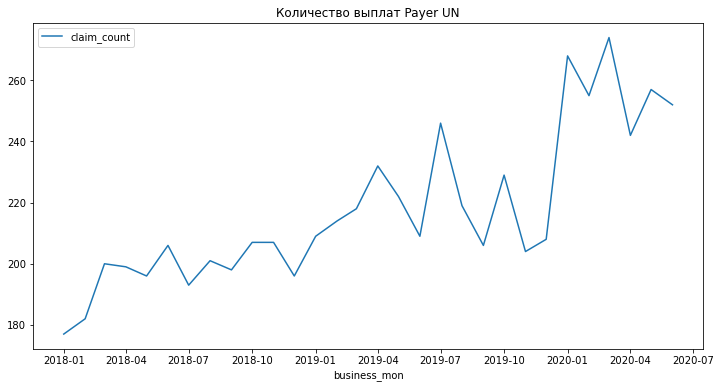

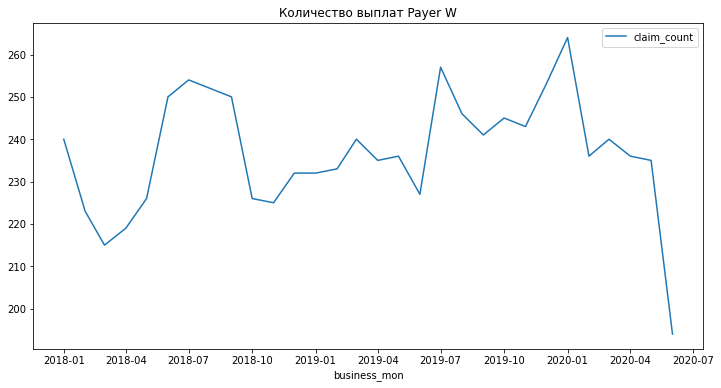

In [40]:
graph_2 = pd_df_stat
graph_2['summ'] = pd.to_numeric(graph_2['claim_count'])*pd.to_numeric(graph_2['mean_paid_amount'])
target_dt = '2020-06-01'
graph_2 = graph_2[(graph_2['business_mon']<=dt_get(target_dt))]

list_payers = pd_df_stat['PAYER'].drop_duplicates().values.tolist()

for n,yy in enumerate(list_payers):
    graph_3 = graph_2[(graph_2['PAYER']==str(yy))]
    graph_3.plot(x = 'business_mon', y='claim_count', kind='line', figsize = (12,6), title='Количество выплат '+ yy
                )

Сумма платежей:

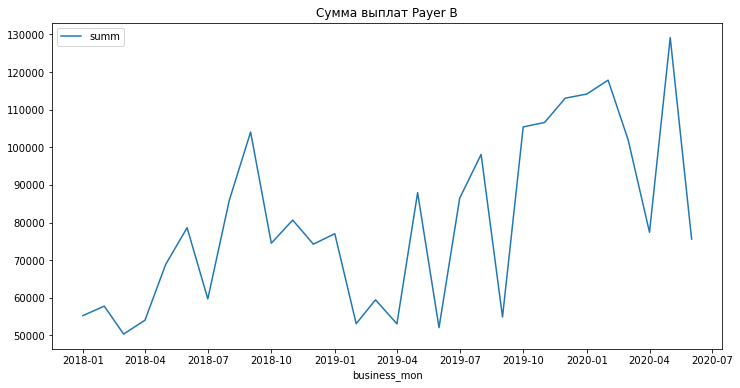

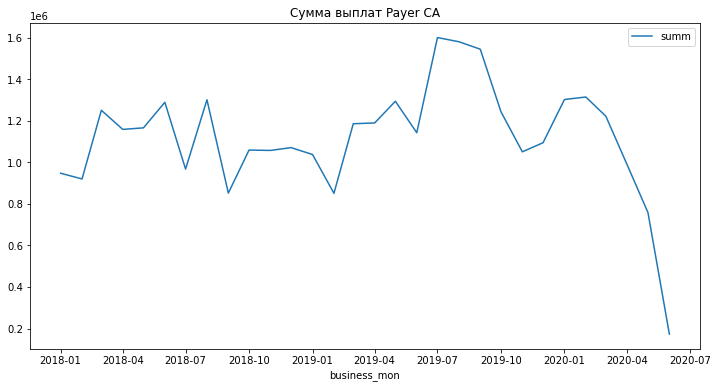

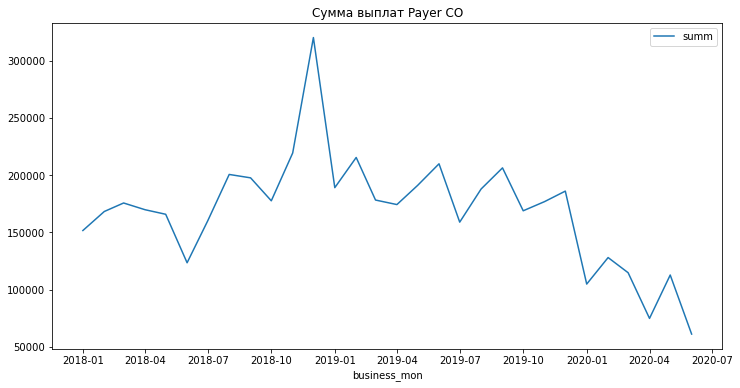

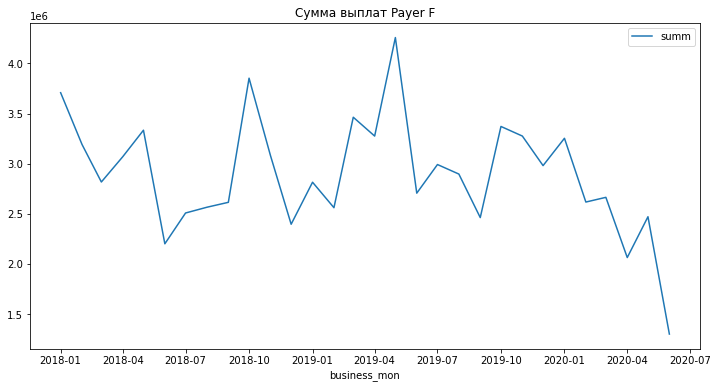

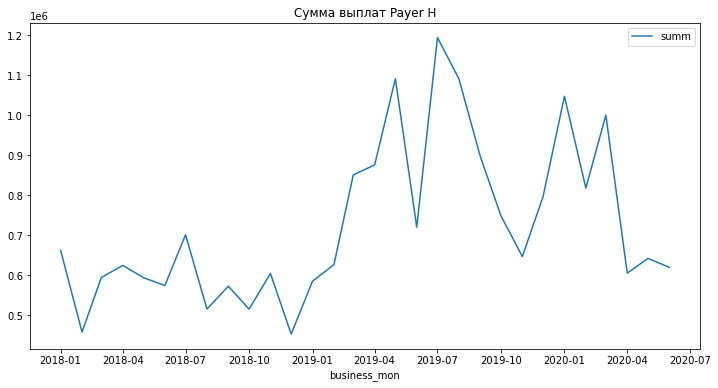

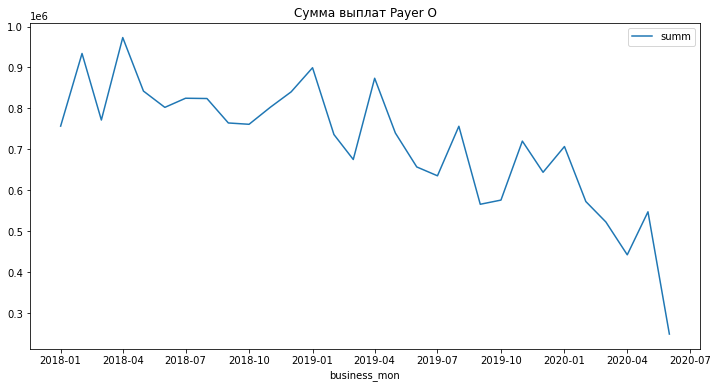

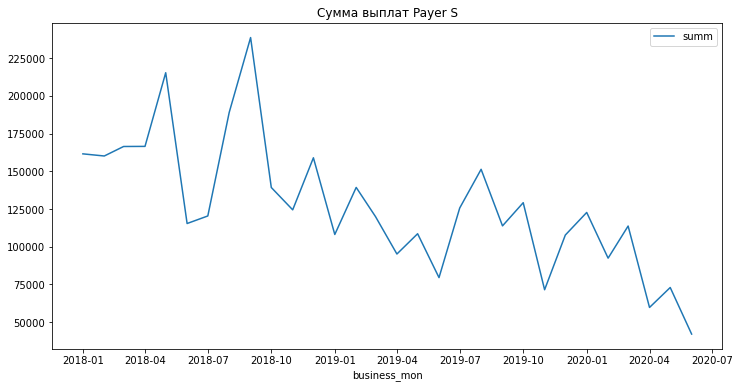

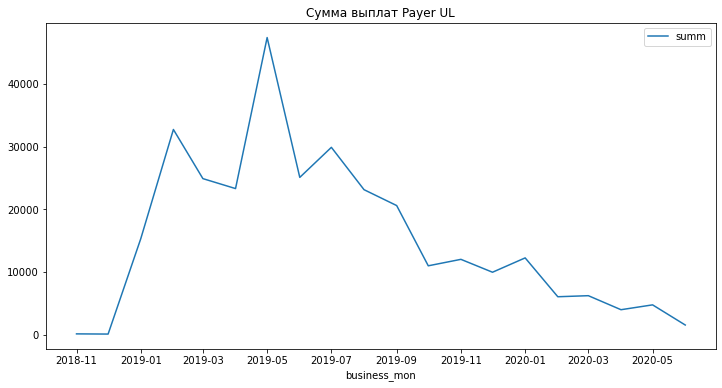

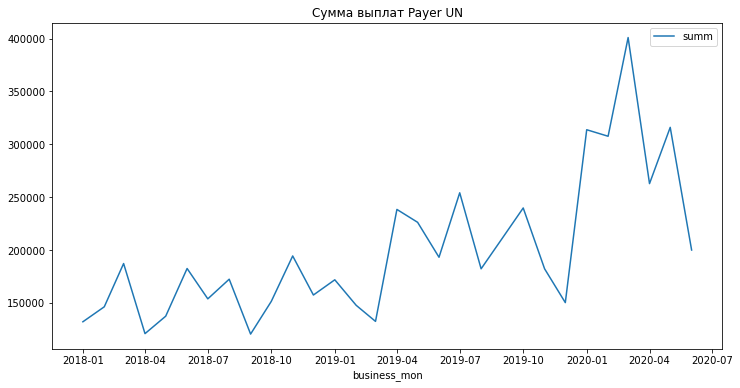

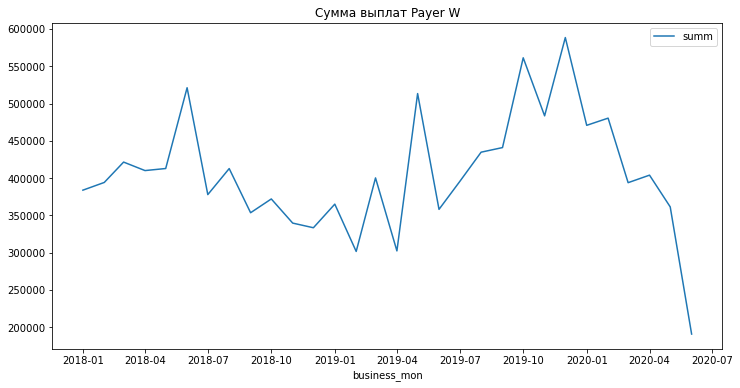

In [42]:
for n,yy in enumerate(list_payers):
    graph_3 = graph_2[(graph_2['PAYER']==str(yy))]
    graph_3.plot(x = 'business_mon', y='summ', kind='line', figsize = (12,6), title='Сумма выплат '+ yy
                )

На данном этапе можем сделать выводы:

1. Общая статистика по компаниям:
    
Компании-лидеры по сумме выплат - Payer F, Payer CA и Payer H. По количеству выплат - Payer F, Payer CA и Payer W. По средней сумме выплат лидируют Payer F и Payer H. При этом, к концу рассматриваемого периода, компании Payer F и Payer CA резко теряют в количестве и сумме выплат, в то время как компания Payer H демонстрирует стабильность (эта единственная компания с целостной статистикой на июль 2020 года.

Компания Payer UL сделала наименьшее количество и общую сумму выплат. Эта компания начала совершать позже других (с ноября 2018 года), и сохранила самый низкий средний "чек" (т.е. среднюю сумма выплат).

2. Детальная ситуация по компаниям:

Компания Payer H демонстрирует относительную стабильность с точки зрения колебаний сумм платежей (для крупного "игрока"). Это достигается в том числе засчёт высокой доли типа услуг "AncillaryFFS" в платежах, платежи которого демонстрируют стабильность в выплаченных суммах у всех рассматриваемых компаний.

Компания UL сделала фокус на услугах с низким средним чеком и немного отличается по профилю долевой разбивки типов услуг в выплатах от других компаний (на первом месте по кличеству выплат идёт тип услуг SpecialistFFS, который у других компаний занимает гораздо более низкую долю). Тем не менее, статистика выплат у данной компании неуклонно снижается (даже несмотря на общий спад, связанный скорее всего с COVID, выплаты компании UL имеют тренд к снижению до начала 2020 года).

Компания UN отличается уникальным профилем фокусировки на группах услуг. Например, у данной компании первая категория по количеству выплат AncillaryFFS, а не SpecialistsFFS, как у остальных компаний, а по сумме выплат SpecialistFFS, вместо InpatientServices, как у остальных. При этом, компания UN демонстрирует относительную стаблиность в количестве и суммах выплат, сохраняя свою нишу.

3. Итог:

Компании H и UN выделяются на общем фоне за счёт относительной стабильности на протяжении рассматриваемого периода. При этом, компания H является одним из лидеров по статистике выплат (объёму и активности), а компания UN заняла свою нишу услуг с низкой средней суммой и продолжает развиваться в условиях спада активности рынка в целом.